Team Members:

1- Gaser Ashraf fayez, Sec: 1, BN: 23

2- Ahmed Mahmoud hafez, Sec: 1 , BN: 11

# lexer
* input: a string
* output: a list of tokens

In [37]:
from enum import Enum,auto
class TokenType(Enum):
  OR = auto()
  STAR = auto()
  PLUS = auto()
  QUESTION_MARK = auto()
  OPEN_PAREN = auto()
  CLOSED_PAREN = auto()
  OPEN_SQUARE_BRACKET = auto()
  CLOSED_SQUARE_BRACKET = auto()
  DASH = auto()
  LITERAL = auto()
def getTypeToken(token):
    if token == '|':
        return TokenType.OR
    elif token == '*':
        return TokenType.STAR
    elif token == '+':
        return TokenType.PLUS
    elif token == '?':
        return TokenType.QUESTION_MARK
    elif token == '(':
        return TokenType.OPEN_PAREN
    elif token == ')':
        return TokenType.CLOSED_PAREN
    elif token == '[':
        return TokenType.OPEN_SQUARE_BRACKET
    elif token == ']':
        return TokenType.CLOSED_SQUARE_BRACKET
    elif token == '-':
        return TokenType.DASH
    else:
        return TokenType.LITERAL
def getTokenValue(token):
    if token==TokenType.OR:
        return '|'
    elif token==TokenType.STAR:
        return '*'
    elif token==TokenType.PLUS:
        return '+'
    elif token==TokenType.QUESTION_MARK:
        return '?'
    elif token==TokenType.OPEN_PAREN:
        return '('
    elif token==TokenType.CLOSED_PAREN:
        return ')'
    elif token==TokenType.OPEN_SQUARE_BRACKET:
        return '['
    elif token==TokenType.CLOSED_SQUARE_BRACKET:
        return ']'
    elif token==TokenType.DASH:
        return '-'
    else:
        return token

class Token:
    ttype: TokenType
    content: str
    def __init__(self, ttype, content):
        self.ttype = ttype
        self.content = content

In [38]:
class regexLexer:
    # input: regex string
    # output: token stream
    def __init__(self, regexStr):
        self.regexStr = regexStr
    def lexer(self):
        tokenStream = []
        for i in range(len(self.regexStr)):
            token = Token(getTypeToken(self.regexStr[i]), self.regexStr[i])
            tokenStream.append(token)
        return tokenStream
    
# regexLexer = regexLexer('a|b')
# tokenStream = regexLexer.lexer()
# for token in tokenStream:
#     print(token.ttype, token.content)


# parser
* input: a list of tokens
* output: a list of AST nodes

In [39]:
from abc import ABC, abstractmethod

class AstNode(ABC):
    @abstractmethod
    def __init__(self):
        pass

class OrAstNode(AstNode):
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
class SeqAstNode(AstNode):
    def __init__(self, left, right):
        self.left = left
        self.right = right
class StarAstNode(AstNode):
    def __init__(self, left):
        self.left = left
class PlusAstNode(AstNode):
    def __init__(self, left):
        self.left = left
class QuestionMarkAstNode(AstNode):
    def __init__(self, left):
        self.left = left
class LiteralCharacterAstNode(AstNode):
    def __init__(self, char):
        self.char = char
class SquareBracketAstNode(AstNode):
    # clas: set #of strs and pairs
    # for example: [a-z] -> {'a', 'b', 'c', ..., 'z'}
    # [a-z0-9] -> {'a', 'b', 'c', ..., 'z', '0', '1', ..., '9'
    # [a-Z012] -> {'a', 'b', 'c', ..., 'Z', '0', '1', '2'}
    def __init__(self, clas):
        self.clas = clas
def print_ast(node, indent=0):
    if isinstance(node, OrAstNode):
        print(' ' * indent + 'OR')
        print_ast(node.left, indent + 2)
        print_ast(node.right, indent + 2)
    elif isinstance(node, SeqAstNode):
        print(' ' * indent + 'SEQ')
        print_ast(node.left, indent + 2)
        print_ast(node.right, indent + 2)
    elif isinstance(node, StarAstNode):
        print(' ' * indent + 'STAR')
        print_ast(node.left, indent + 2)
    elif isinstance(node, PlusAstNode):
        print(' ' * indent + 'PLUS')
        print_ast(node.left, indent + 2)
    elif isinstance(node, QuestionMarkAstNode):
        print(' ' * indent + 'QUESTION_MARK')
        print_ast(node.left, indent + 2)
    elif isinstance(node, LiteralCharacterAstNode):
        print(' ' * indent + 'LITERAL: ' + node.char)
    elif isinstance(node, SquareBracketAstNode):
        print(' ' * indent + 'SQUARE_BRACKET')
        for char in node.clas:
            if isinstance(char, tuple):
                print(' ' * (indent + 2) + 'RANGE: {}-{}'.format(char[0], char[1]))
            else:
                print(' ' * (indent + 2) + 'CHARACTER: {}'.format(char))
    else:
        raise ValueError('Invalid AST node type')

In [40]:
## let's define a CFG for the language
# S -> E
# E -> T '|' E | T
# T -> C F T | C
# F -> '*' | '+' | '?' | epsilon
# C -> L | '(' E ')' | '[' L DASH L ']' | epsilon
# L -> LITERAL | ESCAPED
# OR -> '|' | epsilon
# STAR -> '*' | epsilon
# PLUS -> '+' | epsilon
# QUESTION_MARK -> '?' | epsilon
# OPEN_PAREN -> '(' | epsilon
# CLOSED_PAREN -> ')' | epsilon
# OPEN_SQUARE_BRACKET -> '[' | epsilon
# CLOSED_SQUARE_BRACKET -> ']' | epsilon
# DASH -> '-' | epsilon
# LITERAL -> any character except '|' '*', '+', '?', '(', ')', '[', ']', '\\', and '-' 

class ParseRegex:
    def __init__(self, tokenStream):
        self.tokenStream = tokenStream
        self.currToken = 0

    
    def parse(self):
        ast = self.parse_E()
        if self.currToken < len(self.tokenStream):
            raise Exception("Unexpected token")
        return ast

    def parse_E(self):
        ast = self.parse_T()
        if self.match(TokenType.OR):
            left = ast
            right = self.parse_E()
            ast = OrAstNode(left, right)
        return ast

    def parse_T(self):
        ast = self.parse_C()
        if self.currToken < len(self.tokenStream):
            ttype = self.tokenStream[self.currToken].ttype
            if ttype in [TokenType.LITERAL, TokenType.OPEN_PAREN, TokenType.OPEN_SQUARE_BRACKET]:
                left = ast
                right = self.parse_T()
                ast = SeqAstNode(left, right)
        return ast

    def parse_C(self):
        if self.match(TokenType.LITERAL):
            ast = LiteralCharacterAstNode(self.tokenStream[self.currToken - 1].content)
        elif self.match(TokenType.OPEN_PAREN):
            ast = self.parse_E()
            self.expect(TokenType.CLOSED_PAREN)
        elif self.match(TokenType.OPEN_SQUARE_BRACKET):
            clas = self.parse_L()
            self.expect(TokenType.CLOSED_SQUARE_BRACKET)
            ast = SquareBracketAstNode(clas)
        else:
            ast = AstNode()
        if self.match(TokenType.STAR):
            ast = StarAstNode(ast)
        elif self.match(TokenType.PLUS):
            ast = PlusAstNode(ast)
        elif self.match(TokenType.QUESTION_MARK):
            ast = QuestionMarkAstNode(ast)
        return ast

    def parse_L(self):
        clas = set()
        que = []
        while self.currToken < len(self.tokenStream):
            ttype = self.tokenStream[self.currToken].ttype
            if ttype == TokenType.CLOSED_SQUARE_BRACKET:
                break
            elif ttype == TokenType.LITERAL:
                clas.add(self.tokenStream[self.currToken].content)
                que.append(self.tokenStream[self.currToken].content)
            elif ttype == TokenType.DASH:
                if len(clas) == 0 or self.currToken + 1 == len(self.tokenStream) or self.tokenStream[self.currToken + 1].ttype == TokenType.CLOSED_SQUARE_BRACKET:
                    clas.add('-')
                else:
                    # get last character in que
                    start = ord(que.pop())
                    end = ord(self.tokenStream[self.currToken + 1].content)
                    # print(chr(start), chr(end))
                    for i in range(start, end + 1):
                        clas.add(chr(i))
                    self.currToken += 1
            self.currToken += 1
        return clas

    def match(self, ttype):
        if self.currToken >= len(self.tokenStream):
            return False
        if self.tokenStream[self.currToken].ttype == ttype:
            self.currToken += 1
            return True
        return False

    def expect(self, ttype):
        if not self.match(ttype):
            raise Exception("Expected token", getTokenValue(ttype))
        





# AST to NFA
* input: a list of AST nodes
* output: a NFA 

In [41]:
from collections import deque

class NFA:
    def __init__(self, starting_state,final_state, states):
        self.starting_state = starting_state
        self.final_state = final_state
        self.states = states
    dect = {}
    index = 0
    def stateToNumber(self, state):
        if state in self.dect:
            return str(self.dect[state])
        else:
            self.dect[state] = self.index
            self.index += 1
            return str(self.dect[state])
        
    
    def to_dict(self):
        nfa_dict = {}
        nfa_dict['startingState'] = self.stateToNumber(self.starting_state)
        for state_name, state in self.states.items():
            transitions = {}
            for symbol, next_states in state.items():
                if symbol == '':
                    symbol = 'epsilon'
                arr = []
                for next_state in next_states:
                    arr.append(self.stateToNumber(next_state))
                transitions[symbol] = arr
            
            nfa_dict[self.stateToNumber(state_name)] = {
                'isTerminatingState': self.stateToNumber(state_name) == self.stateToNumber(self.final_state),
                **transitions
            }
            
        return nfa_dict

class ThompsonConstruction:
    def __init__(self, ast):
        self.ast = ast

    def construct(self):
        starting_state, final_state, states = self._construct_from_ast(self.ast)
        return NFA(starting_state,final_state, states)

    def _construct_from_ast(self, node):
        if isinstance(node, LiteralCharacterAstNode):
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {node.char: {final_state}},
                final_state: {'': set()}
            }
            return starting_state, final_state, states
        
        elif isinstance(node, PlusAstNode):
            # (a|epsilon)+
            # one or more
            sub_start, sub_final, sub_states = self._construct_from_ast(node.left)
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {'': {sub_start}},
                **sub_states,
                sub_final: {'': {starting_state, final_state}},
                final_state: {'': set()}
            }
            
            return starting_state, final_state, states
        
        elif isinstance(node, QuestionMarkAstNode):
            # (a|epsilon)?
            # zero or one
            sub_start, sub_final, sub_states = self._construct_from_ast(node.left)
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {'': {sub_start, final_state}},
                **sub_states,
                sub_final: {'': {final_state}},
                final_state: {'': set()}
                
            }
            return starting_state, final_state, states

        elif isinstance(node, SeqAstNode):
            # a.b

            left_start, left_final, left_states = self._construct_from_ast(node.left)
            right_start, right_final, right_states = self._construct_from_ast(node.right)
            states = {**left_states, **right_states, left_final: {'': {right_start}}}
            starting_state = left_start
            final_state = right_final
            return starting_state, final_state, states

        elif isinstance(node, OrAstNode):
            # a|b
            left_start, left_final, left_states = self._construct_from_ast(node.left)
            right_start, right_final, right_states = self._construct_from_ast(node.right)
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {'': {left_start, right_start}},
                **left_states,
                **right_states,
                left_final: {'': {final_state}},
                right_final: {'': {final_state}},
                final_state: {'': set()},
                final_state: {'': set()}
            }
            return starting_state, final_state, states
        
        elif isinstance(node, StarAstNode):
            # (a|epsilon)*
            # zero or more
            sub_start, sub_final, sub_states = self._construct_from_ast(node.left)
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {'': {sub_start, final_state}},
                **sub_states,
                sub_final: {'': {starting_state, final_state}},
                final_state: {'': set()}
            }
            return starting_state, final_state, states
        
        elif isinstance(node, SquareBracketAstNode):
            starting_state = object()
            final_state = object()
            states = {
                starting_state: {char: {final_state} for char in node.clas},
                final_state: {'': set()}
            }
            return starting_state, final_state, states
        
    

In [42]:
import graphviz
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def draw_nfa(nfa):
    dot = graphviz.Digraph(comment='NFA')

    # add invisible starting state
    dot.node('startingStateH', 'startingStateH',style='invis')
    # add nodes
    for key in nfa.keys():
        if key == 'startingState':
            continue
        if nfa[key]['isTerminatingState']:
            dot.node(key, key, shape='doublecircle')
        else:
            dot.node(key, key)
    # add edges
    for key in nfa.keys():
        if key == 'startingState':
            continue
        for symbol in nfa[key].keys():
            if symbol == 'isTerminatingState':
                continue
            for next_state in nfa[key][symbol]:
                sy = symbol
                if symbol == 'epsilon':
                    sy = 'ε'
                dot.edge(key, next_state, label=sy)
    dot.edge('startingStateH',nfa['startingState'])

    return dot

def draw_dfa(dfa):
    dot = graphviz.Digraph(comment='NFA')

    # add invisible starting state
    dot.node('startingStateH', 'startingStateH',style='invis')
    # add nodes
    for key in dfa.keys():
        if key == 'startingState':
            continue
        if dfa[key]['isTerminatingState']:
            dot.node(key, key, shape='doublecircle')
        else:
            dot.node(key, key)
    # add edges
    for key in dfa.keys():
        if key == 'startingState':
            continue
        for symbol in dfa[key].keys():
            if symbol == 'isTerminatingState':
                continue
            next_state= dfa[key][symbol]   
            dot.edge(key, next_state, label=symbol)
    dot.edge('startingStateH',dfa['startingState'])

    return dot

def save_json(nfa, filename):
    import json 
    # Serializing json  
    json_object = json.dumps(nfa, indent = 4) 
    # save to file
    with open(filename, "w") as outfile:
        outfile.write(json_object)

def display_and_save_image(nfa,fileName):
    if fileName == 'nfa_graph':
        dot = draw_nfa(nfa)
    else:
        dot=draw_dfa(nfa)
    dot.format = 'png'
    dot.render(fileName)
    #svg = SVG(data=dot.pipe())._repr_svg_()
    # display nfa_graph.png
    
    img=mpimg.imread(fileName+'.png')
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.figure(figsize=(15, 15))
    plt.show()



# Test req1

In [43]:
import re
def is_valid_regex(regex):
    try:
        re.compile(regex)
        return True
    except re.error:
        return False

In [44]:
def req1(regex):
    print('Req 1 : regex to NFA')
    regexlexer = regexLexer(regex)
    tokenStream = regexlexer.lexer()
    print('AST for regex: ', regex)
    parseRegex = ParseRegex(tokenStream)
    ## handle Exception
    throwException = False
    try:
        AST = parseRegex.parse()
    except Exception as e:
        print(e)
        throwException = True
    if throwException:
        print('Invalid regex')
        return
    print_ast(AST)
    nfa = ThompsonConstruction(AST).construct().to_dict()
    save_json(nfa, "nfa.json")
    print('NFA for regex: ', regex)
    display_and_save_image(nfa,"nfa_graph")

# NFA to DFA

In [45]:
class DFA:
    def __init__(self, alphabet, states, start_state, accept_states, transition_function):
        self.alphabet = alphabet
        self.states = states
        self.start_state = start_state
        self.accept_states = accept_states    
        self.transition_function = transition_function
        self.ma = {}
        self.num = 0
    def run(self, input_string):
        current_state = self.start_state
        for symbol in input_string:
            current_state = self.transition_function[current_state][symbol]
        return current_state in self.accept_states
    def get_state_number(self,state):
        if self.ma.get(state) == None:
            self.ma[state] = self.num
            self.num += 1
        return str(self.ma[state])
    def to_dict(self):
        dfa_dict = {}
        dfa_dict['startingState'] = self.get_state_number(self.start_state)
        for state in self.states:
            if state == 'frozenset()':
                continue
            dfa_dict[self.get_state_number(state)] = {
                "isTerminatingState": state in self.accept_states
            }
            for symbol in self.alphabet:
                if symbol == 'isTerminatingState':
                    continue
                if self.transition_function[state][symbol]!="frozenset()": 
                    dfa_dict[self.get_state_number(state)][symbol] = self.get_state_number(self.transition_function[state][symbol])
        return dfa_dict

class NFAtoDFAConverter:
    def __init__(self, nfa):
        self.nfa = nfa
        self.dfa = self.convert()

    def epsilon_closure(self, states):
        closure = set(states)
        queue = list(states)
        while queue:
            state = queue.pop()
            if state in self.nfa:
                for next_state in self.nfa[state].get("epsilon", []):
                    if next_state not in closure:
                        closure.add(next_state)
                        queue.append(next_state)
        return frozenset(closure)

    def move(self, states, symbol):
        move_states = set()
        for state in states:
            if state in self.nfa:
                # handle if isTerminatingState
                if symbol == 'isTerminatingState':
                    continue
                for next_state in self.nfa[state].get(symbol, []):
                    move_states.add(next_state)
        return frozenset(move_states)

    def convert(self):
        alphabet = set(symbol for state in self.nfa.values() for symbol in state if symbol != "epsilon")
        alphabet.discard("isTerminatingState")
        alphabet.discard(self.nfa["startingState"])
        start_state = self.epsilon_closure([self.nfa["startingState"]])
        dfa_states = [start_state]
        dfa_accept_states = []
        dfa_transition_function = {}
        queue = [start_state]

        while queue:
            current_state = queue.pop(0)
            for symbol in alphabet:
                move_states = self.move(current_state, symbol)
                closure_states = self.epsilon_closure(move_states)

                if closure_states not in dfa_states:
                    dfa_states.append(closure_states)
                    queue.append(closure_states)

                dfa_transition_function.setdefault(current_state, {})
                dfa_transition_function[current_state][symbol] = closure_states

            if any(state in self.nfa and self.nfa[state]["isTerminatingState"] for state in current_state):
                dfa_accept_states.append(current_state)

        # remove empty fozenset from dfa_transition_function
        #dfa_transition_function.pop(frozenset(), None)
        dfa_states = [str(state) for state in dfa_states]
        start_state = str(start_state)
        dfa_accept_states = [str(state) for state in dfa_accept_states]
        dfa_transition_function = {str(k): {symbol: str(v) for symbol, v in transitions.items()} for k, transitions in dfa_transition_function.items()}

        return DFA(alphabet, dfa_states, start_state, dfa_accept_states, dfa_transition_function)



# Minimized DFA

In [46]:
class DFAMinimizer:
    def __init__(self, dfa_dict):
        self.states = list(dfa_dict.keys())
        self.start_state = dfa_dict['startingState']
        self.states.remove('startingState')
        self.alphabet = list(set([k for d in dfa_dict.values() for k in d if k != 'isTerminatingState']))
        self.alphabet.remove(dfa_dict['startingState'])
        self.accept_states = set([s for s in self.states if dfa_dict[s]['isTerminatingState']])
        self.reject_states = set(self.states) - self.accept_states
        self.groups = [self.accept_states, self.reject_states]
        self.partition = self._partition(dfa_dict)
        self.old_dfa_dict = dfa_dict
        

    def _partition(self, dfa_dict):
        # Initialize partition with the accepting and rejecting states
        partition = [self.accept_states.copy(), self.reject_states.copy()]
        #[[acc],[rej]]

       
        
        # Keep refining the partition until it no longer changes
        while True:
           #[ [1,2,3],[4,5,6]]
            groupToIdx = {}
            for i, group in enumerate(partition):
                for state in group:
                    groupToIdx[state] = i

            new_partition = []
            next_states = {}

            #next_states[2]={'a':0,'b':0,'c':'stuck'}
            for group in partition: 
                if len(group) == 0:
                    continue      
                
                for state in group:
                    next_states[state] = {}
                    # state:2
                    # sy : 'a'
                    # 3
                    for symbol in self.alphabet:
                        if symbol in dfa_dict[state]:
                            next_states[state][symbol] = groupToIdx[dfa_dict[state][symbol]]
                        else:
                            next_states[state][symbol] = 'stuck'
            # for they have the same next states, they are in the same group
            for group in partition:
                if len(group) == 0:
                    continue
                if len(group) == 1:
                    new_partition.append(group)
                    continue
                #next_states[2]={'a':0,'b':0,'c':'stuck'}
                #next_states[3]={'a':0,'b':0,'c':'stuck'}
                #sameNextStates[{'a':0,'b':0,'c':'stuck'}] -> [2,3]
                sameNextStates = {}
                for state in group:
                    sameNextStates[tuple(next_states[state].items())] = []
                for state in group:
                    sameNextStates[tuple(next_states[state].items())].append(state)
                for sameNextState in sameNextStates.values():
                    new_partition.append(set(sameNextState))
                
            if new_partition == partition:
                break
            else:
                partition = new_partition
        return partition



    
    def to_dict(self):
        maNewStateNames = {}
        for state in self.states:
            for i, group in enumerate(self.partition):
                if state in group:
                    maNewStateNames[state] = i
                    break
        dfa_dict = {
            "startingState": str(maNewStateNames[self.start_state])
        }
        
        for state in self.states:
            dfa_dict[str(maNewStateNames[state])] = {
                "isTerminatingState": state in self.accept_states
            }
            for symbol in self.alphabet:
                if symbol in self.old_dfa_dict[state]:
                    dfa_dict[str(maNewStateNames[state])][symbol] = str(maNewStateNames[self.old_dfa_dict[state][symbol]])
        
        return dfa_dict



In [47]:
def req2(regex):
    print('Req 2 : NFA to minimized DFA')
    regexlexer = regexLexer(regex)
    tokenStream = regexlexer.lexer()
    print('AST for regex: ', regex)
    parseRegex = ParseRegex(tokenStream)
    ## handle Exception
    throwException = False
    try:
        AST = parseRegex.parse()
    except Exception as e:
        print(e)
        throwException = True
    if throwException:
        print('Invalid regex')

    print_ast(AST)
    nfa = ThompsonConstruction(AST).construct().to_dict()
    converter = NFAtoDFAConverter(nfa)
    dfa = converter.convert().to_dict()
    save_json(dfa, "dfa.json")
    print('DFA for regex: ', regex)
    display_and_save_image(dfa,"dfa_graph")

    minimizer = DFAMinimizer(dfa).to_dict()
    save_json(minimizer, "minimized_dfa.json")
    print('Minimized DFA for regex: ', regex)
    display_and_save_image(minimizer,"minimized_dfa_graph")


# Run

Req 1 : regex to NFA
AST for regex:  ab(b|c)*d+
SEQ
  LITERAL: a
  SEQ
    LITERAL: b
    SEQ
      STAR
        OR
          LITERAL: b
          LITERAL: c
      PLUS
        LITERAL: d
NFA for regex:  ab(b|c)*d+


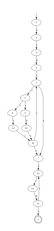

<Figure size 1080x1080 with 0 Axes>

Req 2 : NFA to minimized DFA
AST for regex:  ab(b|c)*d+
SEQ
  LITERAL: a
  SEQ
    LITERAL: b
    SEQ
      STAR
        OR
          LITERAL: b
          LITERAL: c
      PLUS
        LITERAL: d
DFA for regex:  ab(b|c)*d+


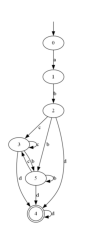

<Figure size 1080x1080 with 0 Axes>

Minimized DFA for regex:  ab(b|c)*d+


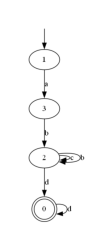

<Figure size 1080x1080 with 0 Axes>

In [48]:
# test complex regex
regexTest1 ='(AB)'
regexTest2 ='(A|B)'
regexTest3 ='([A-Z])'
regexTest4 ='(A+)'
regexTest5 = '(A*)'
regexTest6 = '(((AB)((A|B)*))(AB))'
regexTest7 = '((((AB)|[X-Z])+)([C-F]*))'
regexTest8 = '(((((ABE)|C)|((([A-C])S)*))+)((AB)C))'
regexTest9 = '((([a-e_])(([a-c0-3_])*))(([!?])?))'
regexTest10 = '(A(((B*)|(DA))*))((CG)|(D([DEF])))'
regexTest11 = '(ab'
regexTest12 = '(a([b-c))'
regexTest13 = '((a|b)|)'
regexTest14 = '(a{3,2})'

regexTestBouns1='((((AB)|[A-Z])+)([A-Z]*))'
regexTestBouns2='(((((ABE)|C)|((([A-Z])S)*))+)((AB)C))'
regexTestBouns3='((([a-z_])(([a-z0-9_])*))(([!?])?))'
regex = 'ab(b|c)*d+'
# check if regex is valid
if not is_valid_regex(regex):
    print('invalid regex compilation failed')
else:
    req1(regex)
    req2(regex)
